# Gaussian processes and Bayesian optimization

In this assignment you will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week6()

In [ ]:
! pip install GPy gpyopt xgboost

In [ ]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
from w6_grader import GPGrader
%matplotlib inline

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [ ]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.random.randn(n, 1) * noise_variance**0.5
    return X, y

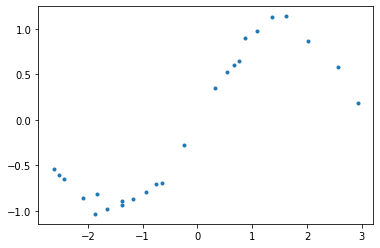

In [ ]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, you will need to define a kernel. For Gaussian (GBF) kernel you can use `GPy.kern.RBF` function.

<b> Task 1.1: </b> Create RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between points `X[5]` and `X[9]`. Submit a single number. 
<br><b>Hint:</b> use `.K` property of kernel object.

In [ ]:
kernel = GPy.kern.RBF(input_dim=1, variance = 1.5, lengthscale=2.)
kernel_59 = kernel.K(np.array([X[5]]), np.array([X[9]]))

{'covariance': [[<matplotlib.lines.Line2D at 0x7f0fce6e9dd0>]]}

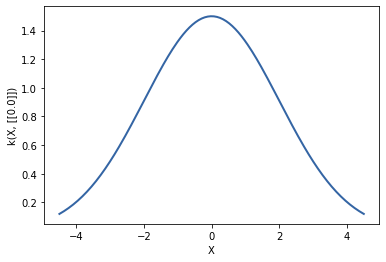

In [ ]:
kernel.plot(ax=plt.gca())

<b> Task 1.2: </b> Fit GP into generated data. Use kernel from previous task. Submit predicted mean and vairance at position $x=1$.
<br><b>Hint:</b> use `GPy.models.GPRegression` class.

In [ ]:
model = GPy.models.GPRegression(X, y, kernel=kernel)
mean, variance = model.predict(np.array([[1]]))

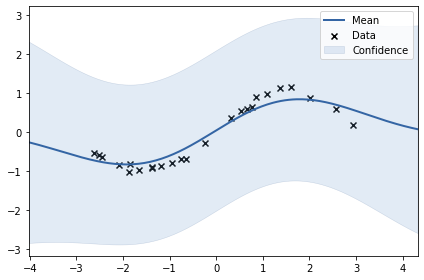

In [ ]:
model.plot()
plt.show()

We see that the model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see the current parameters below:

In [ ]:
model

GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


<b> Task 1.3: </b> Optimize length-scale, variance and noise component of the model and submit optimal length-scale value of the kernel. 
<br><b>Hint:</b> Use `.optimize()` function of the model and `.lengthscale` property of the kernel.

In [ ]:
model.optimize()

In [ ]:
kernel

rbf.,value,constraints,priors
variance,0.7099385192642236,+ve,
lengthscale,1.6252681650349912,+ve,


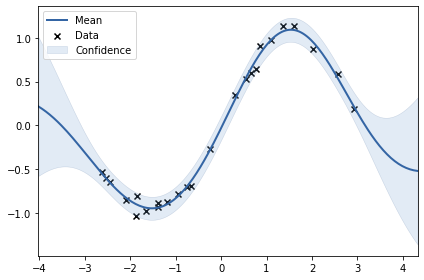

In [ ]:
model.plot()
plt.show()

As you see, the process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into noise or signal.

<b> Task 1.4: </b> Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component.
<br><b>Note:</b> generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

In [ ]:
X, y = generate_noise(noise_variance=10)
kernel = GPy.kern.RBF(input_dim=1, variance = 1.5, lengthscale=2.)
model = GPy.models.GPRegression(X, y, kernel=kernel)
model.optimize()
noise = model.Gaussian_noise.variance

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0fc369e550>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0fc34fb5d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0fc34da3d0>]]}

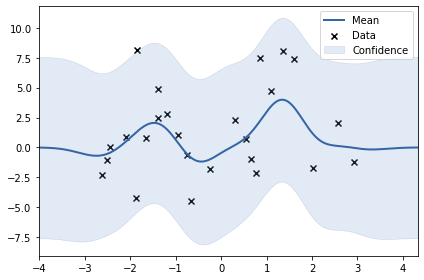

In [ ]:
model.plot()

In [ ]:
X, y = generate_points(noise_variance=0)
kernel = GPy.kern.RBF(input_dim=1, variance = 1.5, lengthscale=2.)
model = GPy.models.GPRegression(X, y, kernel=kernel)
model.optimize()
just_signal = model.Gaussian_noise.variance

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0fc34ecc10>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0fc34573d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0fc3468d90>]]}

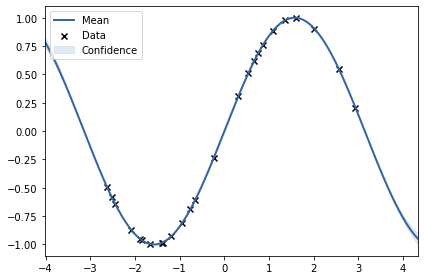

In [ ]:
model.plot()

## Sparse GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure the time that is consumed for prediction of mean and variance for each point. We will then try to use inducing inputs and find the optimal number of points according to quality-time tradeoff.

For the sparse model with inducing points, you should use ```GPy.models.SparseGPRegression``` class. You can set the number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

<b>Task 1.5</b>: Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit `SparseGPRegression` with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [ ]:
X, y = generate_points(1000)

In [ ]:
start = time.time()
kernel = GPy.kern.RBF(input_dim=1, variance = 1.5, lengthscale=2.)
model = GPy.models.GPRegression(X, y, kernel=kernel)
model.optimize()
time_gp = time.time() - start

In [ ]:
start = time.time()
kernel = GPy.kern.RBF(input_dim=1, variance = 1.5, lengthscale=2.)
model = GPy.models.SparseGPRegression(X, y, kernel=kernel, num_inducing=10)
model.optimize()
time_sgp = time.time() - start

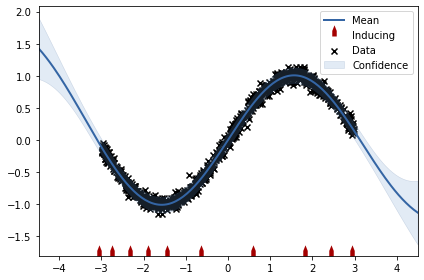

In [ ]:
model.plot()
plt.show()

## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment, we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [ ]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross-validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First, we have to define optimization function and domains.

In [ ]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [ ]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

In [ ]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [ ]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [ ]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

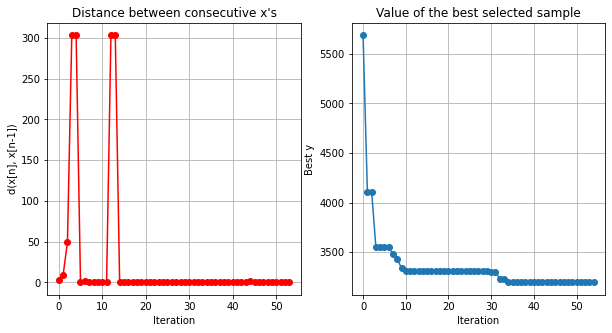

In [ ]:
optimizer.plot_convergence()

Best values of parameters:

In [ ]:
optimizer.X[np.argmin(optimizer.Y)]

array([3.54564002e-02, 1.39689749e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [ ]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3194.559855787982 Gain: 107.5914855997057


We were able to get 9% boost without tuning parameters by hand! Let's see if you can do the same. 

<b>Task 2.1:</b> Tune SVR model. Find optimal values for three parameters: `C`, `epsilon` and `gamma`. Use range (1e-5, 1000) for `C`, (1e-5, 10) for `epsilon` and `gamma`. Use MPI as an acquisition function with weight 0.1. Submit the optimal value of epsilon that was found by a model.

In [ ]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C=parameters[0],
            epsilon=parameters[1],
            gamma=parameters[2],
            ), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

bounds = [
    {'name': 'C',
     'type': 'continuous',
     'domain': (1e-5, 1000)},
    {'name': 'epsilon',
    'type': 'continuous',
    'domain': (1e-5, 10)},
    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-5, 10)},
]

optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

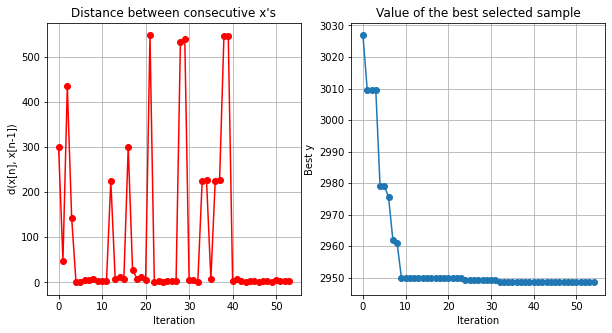

In [ ]:
optimizer.plot_convergence()

In [ ]:
best_epsilon = optimizer.X[np.argmin(optimizer.Y)][1]
mse = np.min(optimizer.Y)

<b>Task 2.2:</b> For the model above submit boost in improvement that you got after tuning hyperparameters (output percents) [e.g. if baseline MSE was 40 and you got 20, output number 200]

In [ ]:
baseline = -cross_val_score(
    SVR(gamma='auto'), X, y, scoring='neg_mean_squared_error'
).mean()
performance_boost = baseline / mse